# Pokemon GAN Training Notebook

## **Import libraries**

In [1]:
import sys
sys.path.append('../sources')

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from dataset import PokemonGensDataset
from ACGAN import AuxGAN
import utils as ut
import os
import variable as var
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [3]:
import torchvision.utils as vutils

In [4]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


total    : 7.77 GB
free     : 2.31 GB
used     : 5.46 GB	(236.43%)


## **Load DATASET**

In [5]:
resume_training = True
train_number = 'example_upsample_7'
gan_id = f"acgan_cp_mnist_train_{train_number}"
n_conv_block = 2
batch_size = 64
output_dim = 32
greyscale = True

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize([output_dim, output_dim]),
    transforms.Normalize(mean=(0.5), std=(0.5))])

In [7]:
train_dataset = datasets.MNIST(root=os.environ['DATASETS'], train=True, transform=transform, download=True)
dloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(f'dataset: {len(train_dataset)} images')

dataset: 60000 images


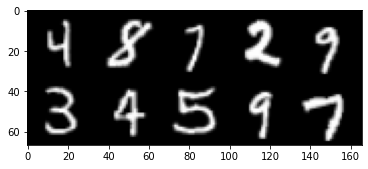

tensor([[4, 8, 7, 2, 9],
        [3, 4, 5, 9, 7]])


In [8]:
images, labels = next(iter(dloader))
ut.show_images_grid(images)
print(labels[:10].reshape(2, 5))

apply weights on inputs based on element wise auxiliary own class probability prediction
to do: in the generator loss function, multiply each sample-loss-value (torch.NLLLoss) value by its own class probability given by the discriminator. 


## **GAN Component**

In [9]:
gen_lr = 5e-4
disc_lr = 5e-4
beta1 = .5
beta2 = .999
betas = {'1': beta1, '2': beta2}
n_channel = 1 if greyscale else 3
n_feature = 26
z_dim = 16
n_classes = 10
use_inception = False
embedding = True
label_smoothing = False
generator_type = 'upsample'

    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': gen_lr,
                  'betas': betas,
                  'embedding': embedding},
          'disc': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': disc_lr,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'n_classes': n_classes,
          'batch_size': batch_size,
          'label_smoothing': label_smoothing,
          'use_inception': use_inception,
          'generator_type': generator_type,
          'output_size': output_dim
         }

## **GAN INIT AND TRAINING**

In [10]:
gan = AuxGAN(params)
checkpoint_path = os.path.join(var.PROJECT_DIR, f'data/models/{gan_id}.pth')
if os.path.exists(checkpoint_path):
    print('RESUMING TRAINING...')
    gan.load_model(checkpoint_path)
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

NEW TRAINING...
id: acgan_cp_mnist_train_example_upsample_7


In [11]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [12]:
gan.train(n_epoch=50, dataloader=dloader, gan_id=gan_id, aux_fake_acc_threshold=1.1)

100%|██████████| 50/50 [15:01<00:00, 18.04s/it]


In [ ]:
ut.show_images_grid(gan.generate_fake(10, being_class=1)[0])

In [7]:
if False:
    ut.delete_gans_id(gan_id)

## **RESULT VIZUALIZATION**

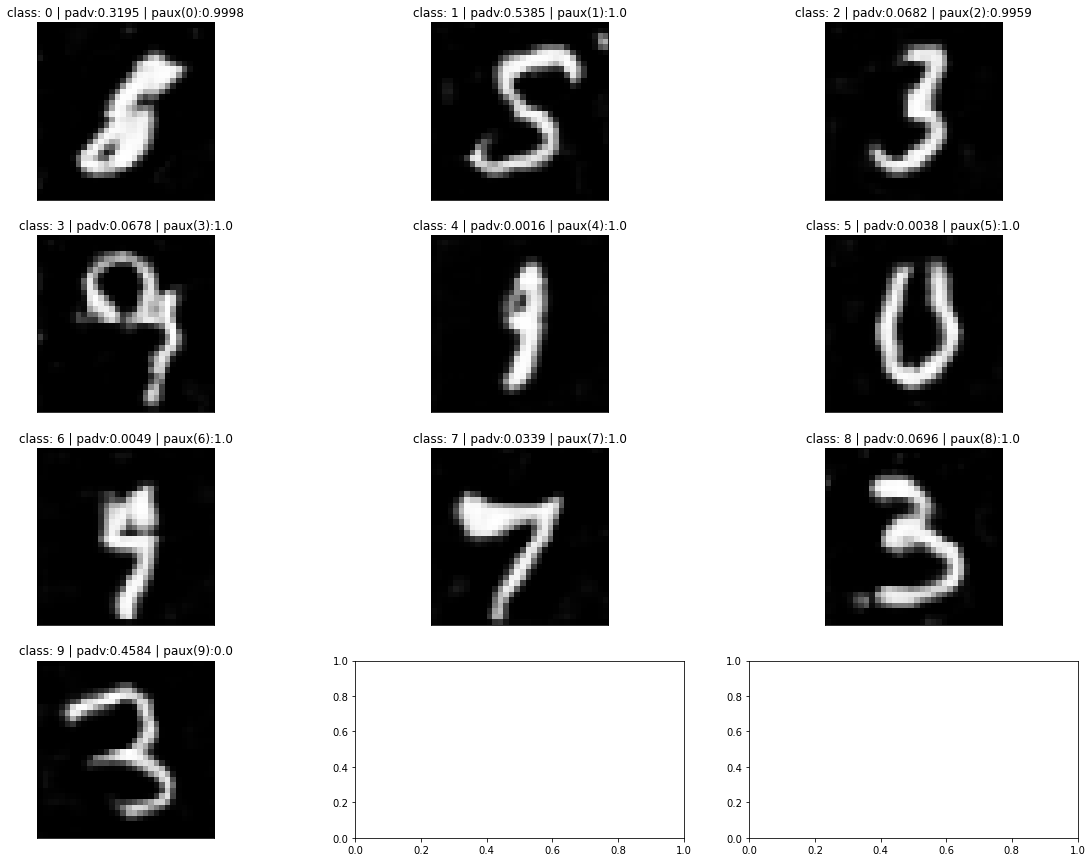

In [17]:
n = 1
# noise = torch.ones(n, z_dim, 1, 1, device=var.device) 
noise = gan.get_random_noise(n)
n_label = n_classes
n_label_per_row = 4
n_label_per_col = (n_label // n_label_per_row) + 1
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_label_per_row, 
                                 ncols=n_label_per_col)
for idx, label_id in enumerate(range(n_classes)):
    
    gan.generator.eval()
    gan.discriminator.eval()
    
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        fakes = gan.generator.forward(noise, classes)
        adv, aux = gan.discriminator(fakes)
        
    i = idx // n_label_per_col
    j = idx % n_label_per_col
    fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
    
    axes[i][j].imshow(fakes_grid)
    axes[i][j].set_title(f"class: {label_id} | padv:{round(adv[0].item(), 4)} | paux({label_id}):{round(aux[0][label_id].item(), 4)}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)
    
    gan.generator.train()
    gan.discriminator.train()
    

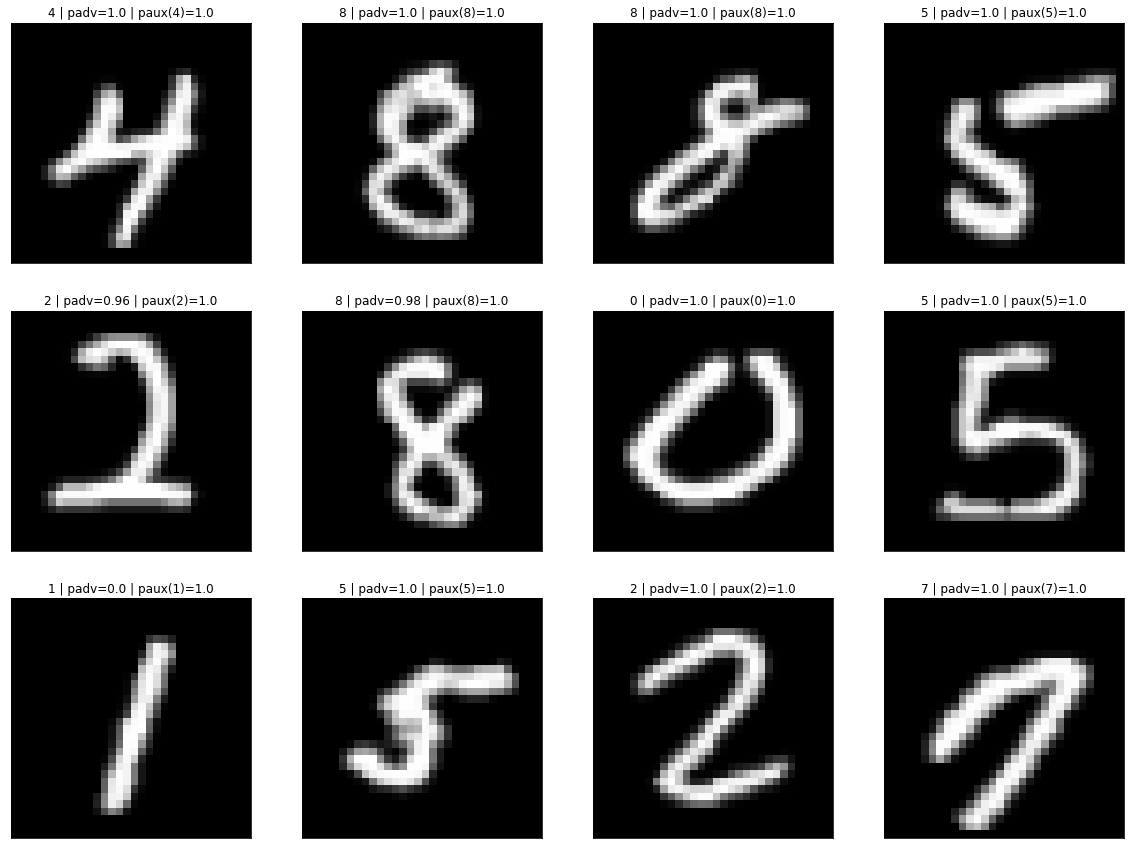

In [48]:
reals, labels = next(iter(dloader))
reals, labels = reals[:12].to(var.device), labels[:12].to(var.device)
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=3, 
                                 ncols=4)
axes = axes.reshape(-1)

for idx, label_id in enumerate(labels):
    adv, aux = gan.discriminator(reals[idx: idx+1])
    reals_grid = ut.images_grid(reals[idx: idx+1], tensorboard=False)
    axes[idx].imshow(reals_grid)
    axes[idx].set_title(f"{label_id} | padv={round(adv[0].item(), 2)} | paux({label_id})={round(aux[0][label_id].item(), 2)}")
    axes[idx].xaxis.set_visible(False)
    axes[idx].yaxis.set_visible(False)

class: 0


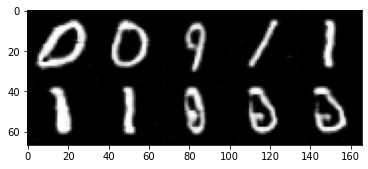

fake/real precision: 1.0
auxiliary precision: 0.7
--------------------------------------------------------------------------
class: 1


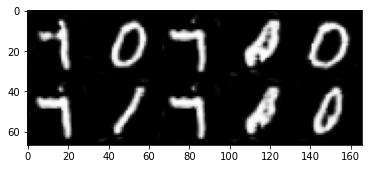

fake/real precision: 1.0
auxiliary precision: 0.8
--------------------------------------------------------------------------
class: 2


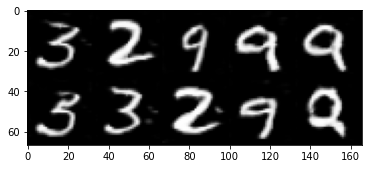

fake/real precision: 1.0
auxiliary precision: 0.8
--------------------------------------------------------------------------
class: 3


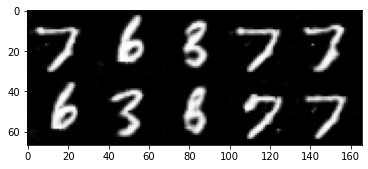

fake/real precision: 1.0
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: 4


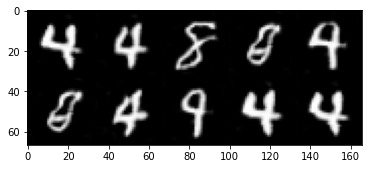

fake/real precision: 0.9
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: 5


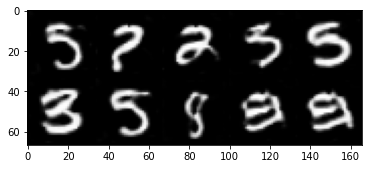

fake/real precision: 1.0
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: 6


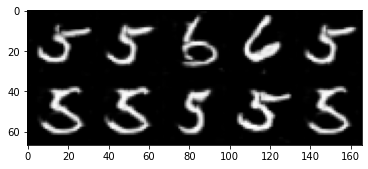

fake/real precision: 1.0
auxiliary precision: 1.0
--------------------------------------------------------------------------
class: 7


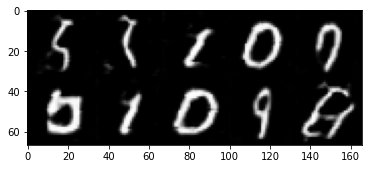

fake/real precision: 1.0
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: 8


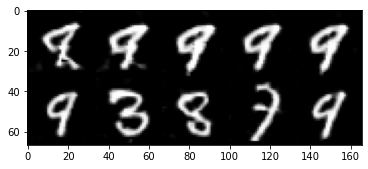

fake/real precision: 1.0
auxiliary precision: 0.9
--------------------------------------------------------------------------
class: 9


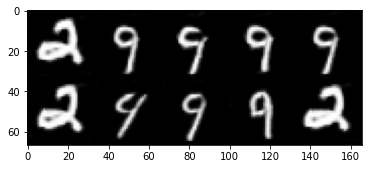

fake/real precision: 1.0
auxiliary precision: 1.0
--------------------------------------------------------------------------


In [53]:
for label_id in range(10):
    print(f"class: {label_id}")
    with torch.no_grad():
        fakes, classes = gan.generate_fake(10, train=False, being_class=label_id)
        adv, aux = gan.discriminator(fakes)
        adv_label = adv < .5
        aux_label = torch.argmax(aux, dim=1) == classes.cuda()

    ut.show_images_grid(fakes)
    print(f"fake/real precision: {round((adv_label.sum()/ len(adv_label)).item(), 3)}")
    print(f"auxiliary precision: {round((aux_label.sum()/ len(aux_label)).item(), 3)}")
    print("--------------------------------------------------------------------------")

In [301]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    max_max_grad = 0.0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            max_grad = p.grad.abs().max()
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(max_grad)
            max_max_grad = max_grad.item() if max_grad.item() > max_max_grad else max_max_grad
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    print(max_grads)

[tensor(5.6651, device='cuda:0'), tensor(37.1417, device='cuda:0'), tensor(1.7497, device='cuda:0'), tensor(30.0315, device='cuda:0'), tensor(0.9447, device='cuda:0'), tensor(10.2452, device='cuda:0'), tensor(0.7397, device='cuda:0'), tensor(5.7435, device='cuda:0'), tensor(1.0466, device='cuda:0'), tensor(3.3919, device='cuda:0'), tensor(0.4834, device='cuda:0'), tensor(2.8198, device='cuda:0'), tensor(0.4163, device='cuda:0'), tensor(4.1677, device='cuda:0'), tensor(0.4484, device='cuda:0'), tensor(1.1201, device='cuda:0'), tensor(0.2270, device='cuda:0'), tensor(1.3180, device='cuda:0'), tensor(0.2039, device='cuda:0'), tensor(3.9053, device='cuda:0'), tensor(0.7421, device='cuda:0'), tensor(0.1336, device='cuda:0'), tensor(0.7735, device='cuda:0'), tensor(0.3978, device='cuda:0'), tensor(4.6653, device='cuda:0'), tensor(0.7022, device='cuda:0'), tensor(0.1534, device='cuda:0'), tensor(0.6080, device='cuda:0'), tensor(0.2281, device='cuda:0'), tensor(1.1207, device='cuda:0'), tensor

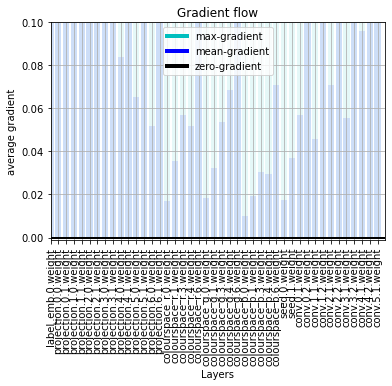

In [302]:
plot_grad_flow(gan.generator.named_parameters())